Link to R sources: https://github.com/MatrixNorm/kaggle/tree/master/R_sources/house_prices

In [1]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))

house_prices <- source('main.R', local = TRUE)$value
missing <- house_prices$missing

combinedDataset <- house_prices$helpers$load_data()
combinedDataset %>% dim %>% show_list

2919 82

### Note

Not all NAs are real missing values.

For some variables e.g. **PoolQC** NAs means absence of a subject. Such NAs are replaced this special **`_none_`** value.

Variables with 'good' NAs:

In [2]:
missing$colums_with_valid_na %>% show_list

(16 elems) Alley BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 BsmtQual Fence FireplaceQu GarageCond GarageFinish GarageQual GarageType MasVnrType MiscFeature PoolQC Utilities

## Visualising missing values in data massive

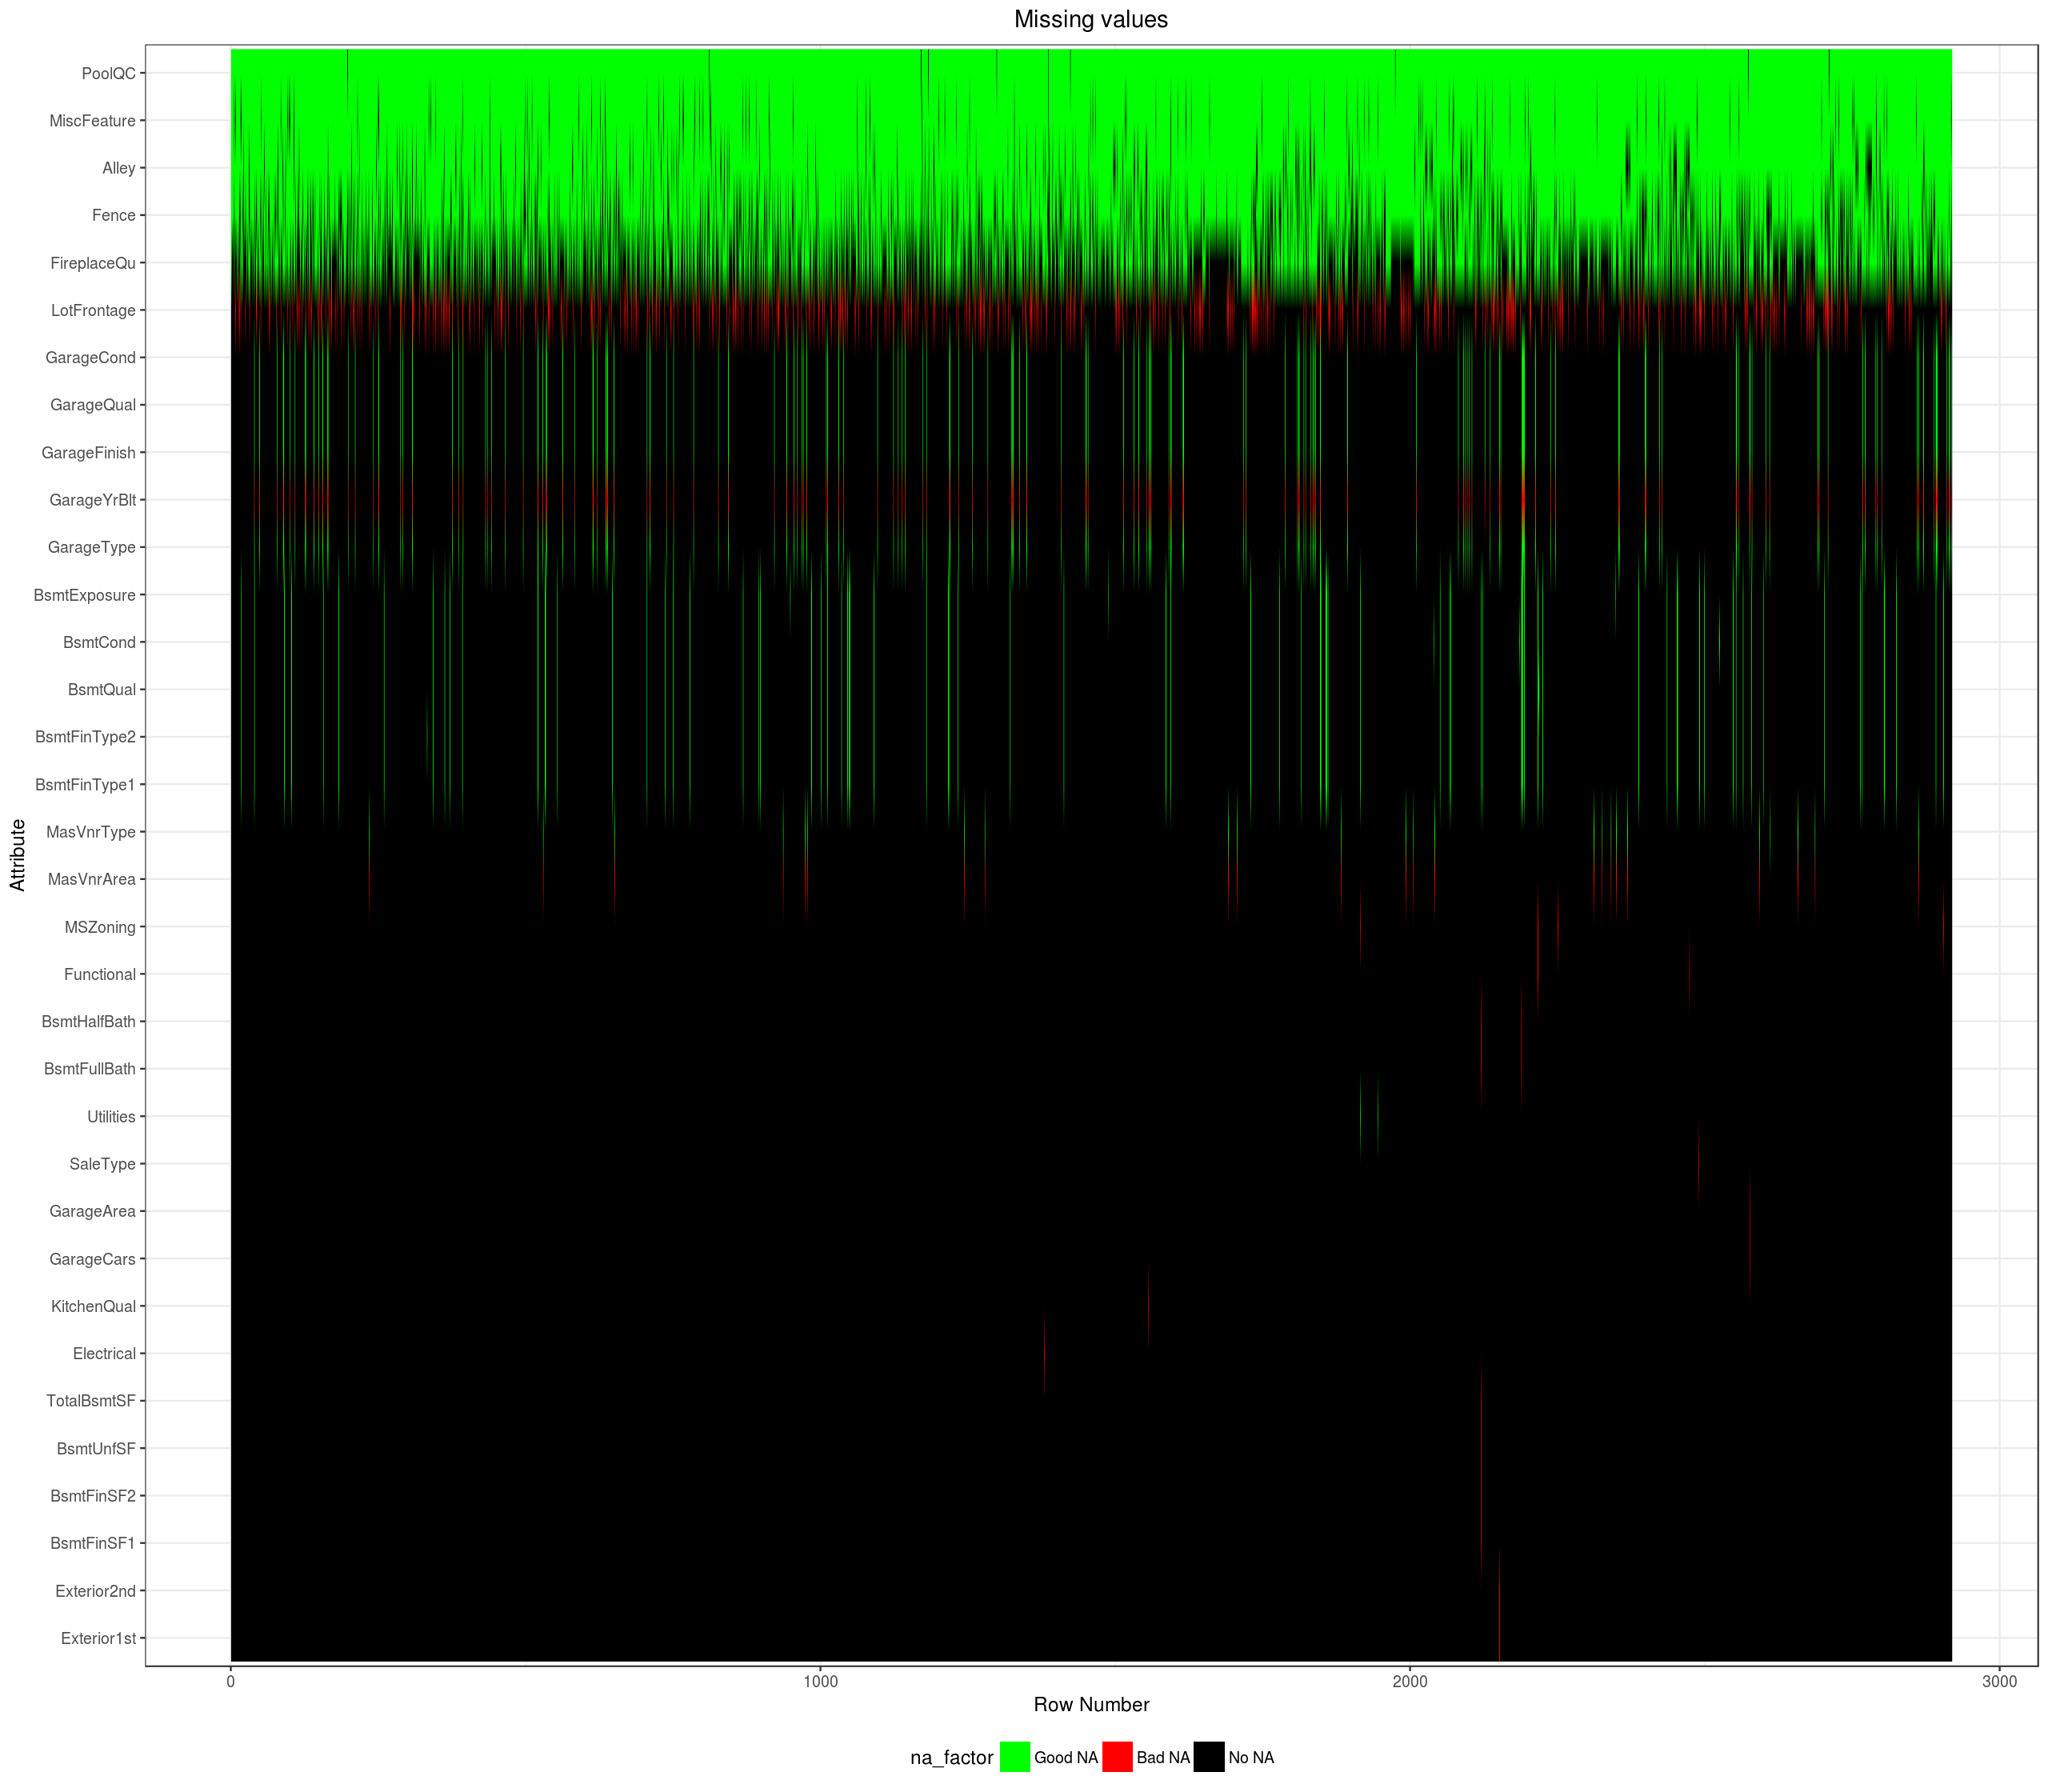

In [7]:
`@@@`(16, 14, 160)

attrs_with_na <- 
    combinedDataset %>% 
    select(-Id, -SalePrice, -dataSource) %>%
    select(which(colSums(is.na(.)) > 0))

# Order attributes by NAs amount
cols_na_order <- attrs_with_na %>% is.na %>% colSums %>% sort %>% names

attrs_with_na %>%
mutate(rnum = row_number()) %>%
gather(col_name, col_value, -rnum) %>% 
mutate(
    is_na = is.na(col_value),
    is_good_na_attr = col_name %in% missing$colums_with_valid_na,
    na_factor = factor(
        case_when(
            is_na & is_good_na_attr ~ 0,
            is_na & !is_good_na_attr ~ 1,
            !is_na ~ 2
        ),
        labels=c("Good NA","Bad NA","No NA")
    )
) %>% 
mutate(
    col_name = factor(col_name, levels=cols_na_order)
) %>%
ggplot() + geom_raster(aes(x=rnum, y=col_name, fill=na_factor), interpolate=TRUE) + 
scale_fill_manual(values=c("green", "red", "black")) + 
theme_bw() +
theme(legend.position="bottom", plot.title = element_text(hjust = 0.5)) +
ylab("Attribute") + xlab("Row Number") +
labs(title = "Missing values")

#### `replace_with_most_common` is applied to categorical variables. 

It finds most common value for a categ variable and patches NAs with this value.

In [11]:
# testing replace_with_most_common
#
fix_by_most_common <- combinedDataset %>% 
                      (missing$categ$replace_with_most_common)

test_that("numeric columns should not be affected", {
    expect_equal(
        combinedDataset %>% select_if(is.numeric),
        fix_by_most_common %>% select_if(is.numeric)
    )
})

test_that("categ columns with `good` NAs should not be affected", {
    expect_equal(
        combinedDataset %>% select(one_of(house_prices$missing$colums_with_valid_na)),
        fix_by_most_common %>% select(one_of(house_prices$missing$colums_with_valid_na))
    )
})

test_that("there should not be NAs in processed columns", {
    
    affected_columns <- 
        setdiff(
            house_prices$helpers$get_character_colnames(combinedDataset),
            missing$colums_with_valid_na
        )
    
    expect_equal(
        sum(is.na(fix_by_most_common %>% select(one_of(affected_columns)))),
        0
    )
})

#### fix_valid applied to factors this 'good' NAs

It replaces NAs with special `_none_` value.

In [12]:
# testing fix_valid
#
fix_valid <- combinedDataset %>% (missing$categ$fix_valid)

test_that("numeric columns should not be affected", {
    expect_equal(
        combinedDataset %>% select_if(is.numeric),
        fix_valid %>% select_if(is.numeric)
    )
})

test_that("categ columns with `bad` NAs should not be affected", {
    
     bad_columns <- 
        setdiff(
            house_prices$helpers$get_character_colnames(combinedDataset),
            house_prices$missing$colums_with_valid_na
        )
    
    expect_equal(
        combinedDataset %>% select(one_of(bad_columns)),
        fix_valid %>% select(one_of(bad_columns))
    )
})

test_that("there should not be NAs in processed columns", {
    
    expect_equal(
        sum(is.na(fix_valid %>% select(one_of(house_prices$missing$colums_with_valid_na)))),
        0
    )
})

#### replace_with_zero is for numeric variables

In [13]:
# testing replace_with_zero
#
fix_by_zero <- combinedDataset %>% (missing$numeric$replace_with_zero)

test_that("categ columns should not be affected", {
    expect_equal(
        combinedDataset %>% select_if(is.character),
        fix_by_zero %>% select_if(is.character)
    )
})

test_that("SalePrice should not be affected", {
    
    expect_equal(
        combinedDataset['SalePrice'],
        fix_by_zero['SalePrice']
    )
})

test_that("there should not be NAs in processed columns", {
    
    expect_equal(
        sum(is.na(fix_by_zero %>% select_if(is.numeric) %>% select(-SalePrice))),
        0
    )
})

#### All in once

In [15]:
# testing all together
#
fixed <- missing$fix_all(combinedDataset)

test_that("should be no NA values except SalePrice column", {
    expect_equal(sum(is.na(fixed %>% select(-SalePrice))), 0)
})

test_that("SalePrice should not be affected", {
    
    expect_equal(
        combinedDataset['SalePrice'],
        fix_by_zero['SalePrice']
    )
})